In [2]:
import os,sys,time
import matplotlib
import numpy as np
from astropy.io import fits
import astroquery
from astroquery.sdss import SDSS

from astropy import coordinates as coords
import astropy.units as u
import astropy.coordinates as coord

import matplotlib.pyplot as plt
import warnings
#from astropy.modeling.blackbody import blackbody_lambda
from scipy import interpolate
from scipy import integrate
from astropy import constants as const
import pandas as pd
# from qsofunc import *
from multiprocessing import Pool
warnings.filterwarnings("ignore")
from scipy.signal import medfilt
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import rc

In [3]:
nonbal_qso_samp_path = '../data/nonbal_qso_samp.csv'
nonbal_qso_samp_df = pd.read_csv(nonbal_qso_samp_path, index_col=0)

In [63]:
nonbal_qso_samp_df.iloc[[1]]

,SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,Z,BAL_PROB,BI_CIV,AI_CIV
1,021542.40+020942.5,33.926674,2.161808,7830,57043,692,QSO,1.792089,0.0,0.0,0.0


In [5]:
hdul = SDSS.get_spectra(plate = nonbal_qso_samp_df.iloc[[0]].PLATE,
                mjd = nonbal_qso_samp_df.iloc[[0]].MJD,
                fiberID = nonbal_qso_samp_df.iloc[[0]].FIBERID)[0]

In [6]:
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  COADD         1 BinTableHDU     26   4626R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5

In [23]:
qso_fits_path = '../data/qso.fits'
hdul.writeto(qso_fits_path, overwrite=True)

In [7]:
hdr = hdul[0]
hdr.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
BOSSVER = '2       '           / ICC version                                    
MJD     =                56240 / APO fMJD day at start of exposure              
MJDLIST = '56240   '           /                                                
NAME    = '6255-56240-01'      / The name of the currently loaded plate         
PLATEID =                 6255 / The currently loaded plate                     
TILEID  =                15188 /Cartridge used in this plugging                 
CARTID  =                   

In [ ]:
hdr

In [ ]:
hdul['SPALL'].header

In [ ]:
hdul['SPALL'].data

In [ ]:
hdul['SPZLINE'].header

In [ ]:
hdul[4].header

In [ ]:
hdul['COADD'].data

In [8]:
from astropy.table import Table
spectra_df = Table(hdul[4].data).to_pandas()

<Axes: xlabel='loglam'>

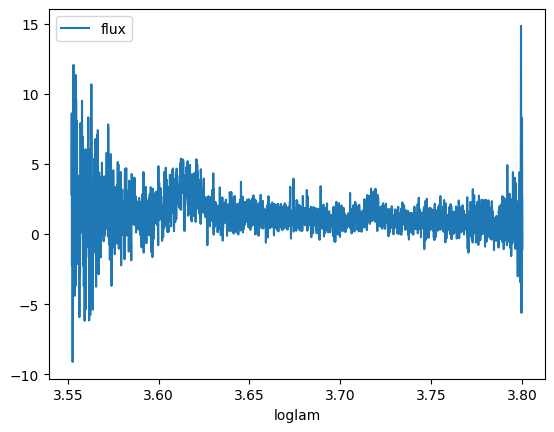

In [9]:
spectra_df.plot('loglam', 'flux')

In [ ]:
for idx, row in nonbal_qso_samp_df.iloc[[0]].iterrows():
    op_filename = f"op-{row['PLATE']}-{row['MJD']}-{row['FIBERID']}"
    print(op_filename)
    op_data = fits.getdata('./download/'+op_filename+'.fits', 1)
    # extension=1: main results
    op_data_MC = fits.getdata('./download/'+op_filename+'.fits', 2)
    # extension=2: MC results
    op_data_spec = fits.getdata('./download/'+op_filename+'.fits', 3)
    # extension=3: processed spectra

    # processed spectrum
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    ax.tick_params(which="both",bottom=True, top=True, left=True, right=True)
    ax.errorbar(op_data_spec.wave_prereduced, op_data_spec.flux_prereduced, yerr=op_data_spec.err_prereduced, \
                color='k', ecolor='silver', label='data', zorder=1)
    ax.xaxis.set_major_locator(MultipleLocator(250.))
    ax.xaxis.set_minor_locator(MultipleLocator(50.))
    ax.yaxis.set_major_locator(MultipleLocator(100.))
    ax.yaxis.set_minor_locator(MultipleLocator(50.))
    ax.set_title(op_filename[3:])
    ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
    ax.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
    ax.set_xlim(op_data_spec.wave_prereduced.min(), op_data_spec.wave_prereduced.max())
    med_flux = medfilt(op_data_spec.flux_prereduced, kernel_size=5)
    ax.set_ylim(-1.2*abs(med_flux.min()), 1.2*med_flux.max())
    set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)
    plt.show()

In [10]:
obj_plate, obj_mjd, obj_fiber = 5808, 56325, 560             # input the objID
op_filename = 'op-%04d'%obj_plate+'-%5d'%obj_mjd+'-%04d'%obj_fiber

In [ ]:
# read output data

op_data = fits.getdata('./download/'+op_filename+'.fits', 1)
# extension=1: main results

op_data_MC = fits.getdata('./download/'+op_filename+'.fits', 2)
# extension=2: MC results

op_data_spec = fits.getdata('./download/'+op_filename+'.fits', 3)
# extension=3: processed spectra

In [ ]:
# processed spectrum
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.tick_params(which="both",bottom=True, top=True, left=True, right=True)
ax.errorbar(op_data_spec.wave_prereduced, op_data_spec.flux_prereduced, yerr=op_data_spec.err_prereduced, \
            color='k', ecolor='silver', label='data', zorder=1)
ax.xaxis.set_major_locator(MultipleLocator(250.))
ax.xaxis.set_minor_locator(MultipleLocator(50.))
ax.yaxis.set_major_locator(MultipleLocator(100.))
ax.yaxis.set_minor_locator(MultipleLocator(50.))
ax.set_title(op_filename[3:])
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
ax.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
ax.set_xlim(op_data_spec.wave_prereduced.min(), op_data_spec.wave_prereduced.max())
med_flux = medfilt(op_data_spec.flux_prereduced, kernel_size=5)
ax.set_ylim(-1.2*abs(med_flux.min()), 1.2*med_flux.max())
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)
plt.show()

In [11]:
import astroML
from astroML.datasets import fetch_sdss_spectrum

In [12]:
nonbal_qso_samp_df.iloc[[0]]

,SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,Z,BAL_PROB,BI_CIV,AI_CIV
0,010754.97+261427.1,16.979045,26.240866,6255,56240,62,QSO,2.373,0.0,0.0,0.0


In [ ]:
SDSS.query_specobj()

In [ ]:
"http://dr18.sdss.org/sas/dr18/prior-surveys/sdss4-dr17-eboss/photoObj/frames/301/1239/6/frame-u-001239-6-0145.fits.bz2"

In [14]:
from astroML.datasets.tools.sdss_fits import SDSSfits

In [24]:
SDSSfits(source=qso_fits_path)

KeyError: "Keyword 'SPEC_CLN' not found."

In [31]:
hdul[0].header['z']

KeyError: "Keyword 'Z' not found."

In [35]:
import os 
import re
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
from src.astroML.datasets.tools.download import download_with_progress_bar

In [41]:
download_url = 'https://data.sdss.org/sas/dr16/eboss/spectro/redux/v5_13_0/spectra/full/6255/spec-6255-56240-0001.fits'



buffer = download_with_progress_bar(download_url, return_buffer=True)

[========================================]  956.2kb / 956.2kb   


In [46]:
hdul = fits.open(buffer)

OSError: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True

In [44]:
fits_f.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1                1 BinTableHDU     33   4627R x 8C   [E, E, E, J, J, E, E, E]   
  2                1 BinTableHDU    501   1R x 236C   [4A, 6A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 6A, D, D, 3A, A, E, E, E, J, E, 21A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, A, A, A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, A, E, 35E, 19A, A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E,

In [48]:
hdul[0].header['NAME']

'6255-56240-01'

In [57]:
h_str = hdul[0].header

In [58]:
h_str

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
BOSSVER = '2       '           / ICC version                                    
MJD     =                56240 / APO fMJD day at start of exposure              
MJDLIST = '56240   '           /                                                
NAME    = '6255-56240-01'      / The name of the currently loaded plate         
PLATEID =                 6255 / The currently loaded plate                     
TILEID  =                15188 /Cartridge used in this plugging                 
CARTID  =                   

In [62]:
hdul[0].data

In [13]:
for idx, row in nonbal_qso_samp_df.iloc[[0]].iterrows():
    spec = fetch_sdss_spectrum(plate=row['PLATE'], mjd=row['MJD'], fiber=row['FIBERID'])
    # spec = SDSS.query_specobj(plate=row['PLATE'], mjd=row['MJD'], fiberID=row['FIBERID'])

HTTPError: HTTP Error 404: Not Found

In [ ]:
spec

In [1]:
nonbal_qso_samp_df

NameError: name 'nonbal_qso_samp_df' is not defined